# Markowitz Model

## Install External Libraries

In [0]:
!pip install PyPortfolioOpt
!pip install yfinance

## Import dependencies

In [0]:
import matplotlib
import pypfopt
import datetime
import math

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Set Local Variables

In [0]:
risk_free_rate = 0.06501 # Risk-free rate of return, 10Yr Treasury Bond Yield
trading_days = 240 # No of trading days in a year

start_date = datetime.date(2000, 1, 1) # Oldest date to be considered for price analysis
investment_date = datetime.date(2019, 1, 1) # Date when funds are invested 
investment_end = datetime.date(2020, 5, 1) # Date of end of investment period

In [0]:
asset_universe = ['HDFC.BO', 'BAJFINANCE.BO', 'SBIN.BO', 'TITAN.BO', 'HDFCBANK.BO', 
                  'HEROMOTOCO.BO', 'INFY.BO', 'KOTAKBANK.BO', 'ONGC.BO', 'RELIANCE.BO',
                  'TATASTEEL.BO', 'LT.BO', 'M&M.BO', 'HINDUNILVR.BO', 'NESTLEIND.BO',
                  'ASIANPAINT.BO', 'ITC.BO', 'SUNPHARMA.BO', 'ICICIBANK.BO', 'INDUSINDBK.BO',
                  'AXISBANK.BO', 'HCLTECH.BO', 'BHARTIARTL.BO', 'MARUTI.BO','ULTRACEMCO.BO',
                  'TCS.BO', 'NTPC.BO', 'TECHM.BO', 'POWERGRID.BO','BAJAJ-AUTO.BO'
]

## Process Historical Data

In [0]:
# Download historical closing prices
sensex30_history = yf.download(asset_universe, start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']
sensex_history = yf.download('^BSESN', start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
# Rename Data Columns
rename_col_dict = dict()
for ticker in sensex30_history.columns:
  rename_col_dict[ticker] = ticker[:-3]

sensex30_history = sensex30_history.rename(columns=rename_col_dict)

## Compute and Plot Expected Returns

In [0]:
# Compute expected returns
sensex30_prices = sensex30_history.loc[start_date:investment_date , :].copy()

# Compute annualised mean daily returns of 30 stocks using data since 2009
mean_daily_returns = sensex30_prices.pct_change().dropna(how="all").mean()

# Annualise mean daily returns via compounding
expected_returns = (1 + mean_daily_returns) ** trading_days - 1

In [0]:
# Plot Expected Returns

plt.style.use("seaborn-whitegrid")
(expected_returns).plot(kind="barh")
plt.ylabel("Stock Tickers")
plt.xlabel("Expected Return")
plt.show()

## Compute and Plot Covariance Matrix

In [0]:
# Compute Covariance Matrix
cov_matrix = pypfopt.risk_models.CovarianceShrinkage(sensex30_prices, frequency=trading_days).ledoit_wolf(shrinkage_target="constant_correlation")

# Convert Covariance Matrix to Correlation Matrix
inv_diag = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
corr_matrix = pd.DataFrame(np.dot(inv_diag, np.dot(cov_matrix, inv_diag)), index=cov_matrix.index, columns=cov_matrix.columns)

In [0]:
# Plot Covariance Matrix Heatmap

plt.style.use("default")

fig, ax = plt.subplots()
corr_ax = ax.imshow(corr_matrix, cmap='magma')

fig.colorbar(corr_ax)
ax.set_xticks(np.arange(0, corr_matrix.shape[0], 1))
ax.set_xticklabels(corr_matrix.index)
ax.set_yticks(np.arange(0, corr_matrix.shape[0], 1))
ax.set_yticklabels(corr_matrix.index)
plt.xticks(rotation=90)

plt.show()

## Compute and Plot Efficient Frontier

<Figure size 3200x2400 with 0 Axes>

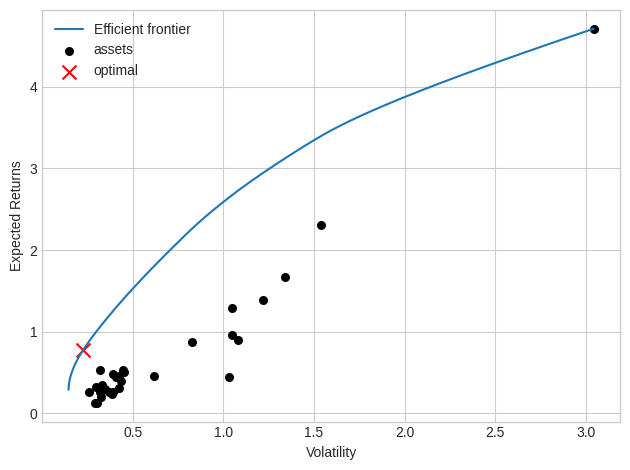

In [0]:
ef_cla = pypfopt.cla.CLA(expected_returns, cov_matrix)


plt.style.use('seaborn-whitegrid')
pypfopt.plotting.Plotting.plot_efficient_frontier(ef_cla, show_assets=True, points=100000, showfig=False)
plt.ylabel("Expected Returns")
plt.grid(True)

plt.show()

## Optimal Portfolio: Max Sharpe Ratio

In [0]:
ef = pypfopt.efficient_frontier.EfficientFrontier(expected_returns, cov_matrix)
ef.max_sharpe(risk_free_rate)
max_sharpe_wts = ef.clean_weights()

ef.portfolio_performance(verbose=True)

max_sharpe_nonzero_wts = dict()
for key, val in max_sharpe_wts.items():
  if val != 0:
    max_sharpe_nonzero_wts[key] = val

Expected annual return: 86.1%
Annual volatility: 25.2%
Sharpe Ratio: 3.33


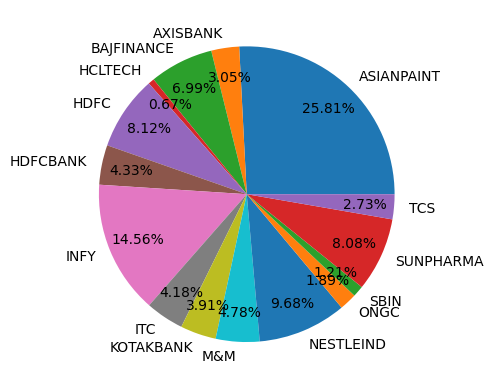

In [0]:
# Plot Maximum Sharpe Ratio Portfolio
plt.style.use("default")
plt.pie(max_sharpe_nonzero_wts.values(), labels=max_sharpe_nonzero_wts.keys(), autopct="%.2f%%", pctdistance=0.8)
plt.show()

## Optimal Portfolio: Min Volatility

In [0]:
risk_free_rate = 0.0654 # Risk-free rate of return, 10Yr Treasury Bond Yield

ef = pypfopt.efficient_frontier.EfficientFrontier(expected_returns, cov_matrix)
ef.min_volatility()
min_volatility_wts = ef.clean_weights()
ef.portfolio_performance(verbose=True)

min_volatility_nonzero_wts = dict()
for key, val in min_volatility_wts.items():
  if val != 0:
    min_volatility_nonzero_wts[key] = val

Expected annual return: 28.7%
Annual volatility: 14.6%
Sharpe Ratio: 1.83


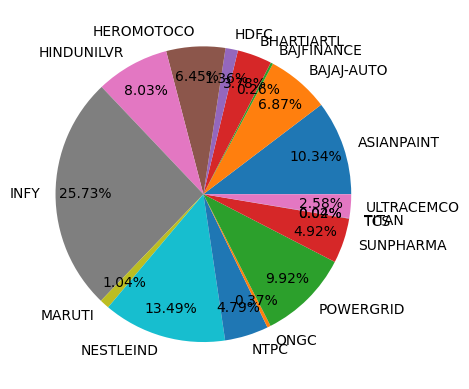

In [0]:
# Plor Minimum Volatility Portfolio
plt.style.use("default")
plt.pie(min_volatility_nonzero_wts.values(), labels=min_volatility_nonzero_wts.keys(), autopct="%.2f%%", pctdistance=0.8)
plt.show()

## Performance Analysis of Markowitz Model

In [0]:
# Slice price datasets to required time-ranges
sensex_prices = sensex_history.loc[investment_date:investment_end].copy()
sensex30_prices = sensex30_history.loc[investment_date:investment_end].copy()

In [0]:
# Create dataframe to analyse portfolio performance
portfolio_performance = pd.DataFrame(index=sensex_prices.index)

# Import Sensex benchmark price value data
portfolio_performance['Sensex'] = sensex_prices

In [0]:
# Import Max Sharpe portfolio price value
max_sharpe_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in max_sharpe_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  max_sharpe_val[index] = val

portfolio_performance['Max Sharpe'] = max_sharpe_val

In [0]:
# Import Min Volatility portfolio price value
min_volatility_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in min_volatility_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  min_volatility_val[index] = val

portfolio_performance['Min Volatility'] = min_volatility_val

In [0]:
# Compute and Plot Relative Portfolio Performance
portfolio_performance = portfolio_performance.pct_change()

# Normalise data to measure relative percentage change over time
for label, content in portfolio_performance.iteritems():
  for index, value in content.iteritems():
    if math.isnan(value):
      portfolio_performance.loc[index, label] = 100
      prev_index = index
    else:
      portfolio_performance.loc[index, label] = portfolio_performance.loc[prev_index, label] * (1 + value)
      prev_index = index

<Figure size 3200x2400 with 0 Axes>

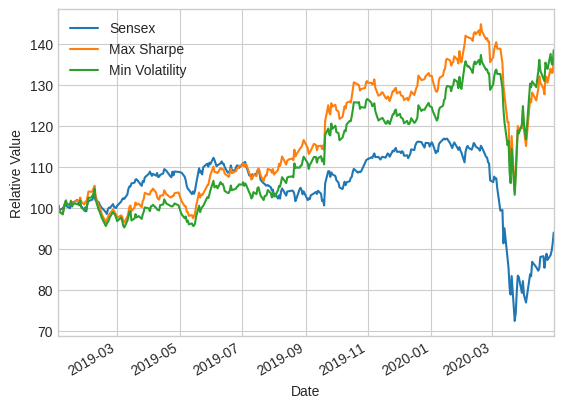

In [0]:
# Plot Relative Value Graph
plt.style.use('seaborn-whitegrid')
portfolio_performance.plot(grid=True)
plt.ylabel("Relative Value")
plt.show()

In [0]:
# Print LaTeX-friendly portfolio compositions
for ticker in sensex30_prices.columns.values:
  print(ticker + ' & ' + str(round(max_sharpe_wts[ticker]*100, 2)) + '\% & ' + str(round(min_volatility_wts[ticker]*100, 2)) + '\% \\\\' )